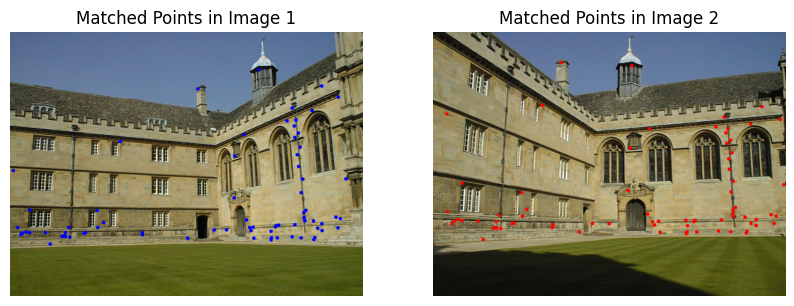

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# 카메라 내부 파라미터 설정
fx, fy = 1086, 1086
cx, cy = 512, 384
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
# 왜곡 계수 설정 
dist_coeffs = -0.0568965

# 이미지와 2D 포인트 파일 경로 설정
img1_path = '../auto_two-view_reconstruction/hw6_data/003.jpg'
img2_path = '../auto_two-view_reconstruction/hw6_data/005.jpg'

# 이미지 로드
img1 = cv.imread(img1_path)
img2 = cv.imread(img2_path)
assert img1 is not None and img2 is not None, "이미지를 로드할 수 없습니다."

# SIFT 특징 추출기 생성
sift = cv.SIFT_create()

# 키포인트와 디스크립터 추출
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# 매칭을 위한 FLANN 기반 매처 설정
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# 디스크립터 매칭
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# 좋은 매칭 포인트 선택 (비율 테스트)
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# 매칭된 포인트를 RANSAC을 사용하여 필터링
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

E, mask = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)
inliers1 = pts1[mask.ravel() == 1]
inliers2 = pts2[mask.ravel() == 1]

# 이미지에 매칭된 포인트 시각화
def plot_points(img, points, color=(0, 255, 0)):
    img_with_points = img.copy()
    for x, y in points:
        cv.circle(img_with_points, (int(x), int(y)), 5, color, -1)
    return img_with_points

# 매칭된 포인트 시각화
img1_with_points = plot_points(img1, inliers1, color=(255, 0, 0))  # 빨간색 포인트
img2_with_points = plot_points(img2, inliers2, color=(0, 0, 255))  # 파란색 포인트

# 시각화 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1_with_points, cv.COLOR_BGR2RGB))
plt.title("Matched Points in Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2_with_points, cv.COLOR_BGR2RGB))
plt.title("Matched Points in Image 2")
plt.axis('off')
plt.show()

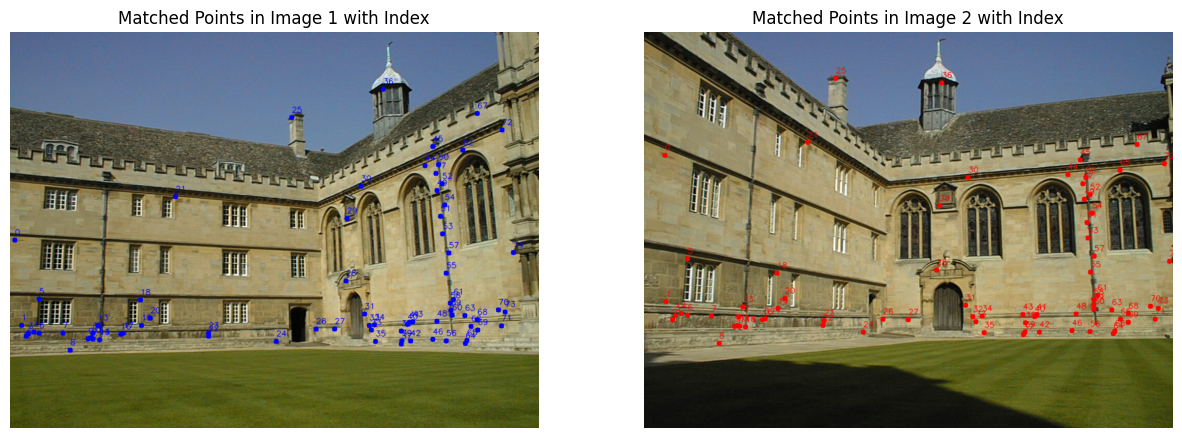

In [7]:
# 이미지에 포인트와 인덱스를 시각화하는 함수
def plot_points_with_index(img, points, color=(0, 255, 0)):
    img_with_points = img.copy()
    for i, (x, y) in enumerate(points):
        cv.circle(img_with_points, (int(x), int(y)), 5, color, -1)
        cv.putText(img_with_points, str(i), (int(x), int(y) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv.LINE_AA)
    return img_with_points

# 매칭된 포인트 시각화 (인덱스 추가)
img1_with_points = plot_points_with_index(img1, inliers1, color=(255, 0, 0))  # 빨간색 포인트
img2_with_points = plot_points_with_index(img2, inliers2, color=(0, 0, 255))  # 파란색 포인트

# 시각화 결과 출력
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1_with_points, cv.COLOR_BGR2RGB))
plt.title("Matched Points in Image 1 with Index")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2_with_points, cv.COLOR_BGR2RGB))
plt.title("Matched Points in Image 2 with Index")
plt.axis('off')
plt.show()


In [8]:
inlier_count = np.sum(mask)
total_matches = len(good_matches)
inlier_ratio = inlier_count / total_matches
print(f"Inlier Ratio: {inlier_ratio:.2f}")


Inlier Ratio: 0.52


In [9]:
# 필수 행렬(Essential Matrix) 계산
points1 = pts1.reshape(-1, 1, 2)
points2 = pts1.reshape(-1, 1, 2)
points1_undist = cv.undistortPoints(points1, K, dist_coeffs)
points2_undist = cv.undistortPoints(points2, K, dist_coeffs)
E, _ = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)
print("Essential Matrix (E):\n", E)

# 회전(R) 및 변환(t) 추출
_, R, t, _ = cv.recoverPose(E, pts1, pts2, K)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t)

Essential Matrix (E):
 [[-0.00466844 -0.17416927  0.0301439 ]
 [-0.35818777  0.00915789 -0.60901944]
 [ 0.07300321  0.680802   -0.02503516]]
Rotation Matrix (R):
 [[ 0.69966911 -0.14001093 -0.70061407]
 [ 0.13391748  0.98893074 -0.06389136]
 [ 0.70180428 -0.04912166  0.7106742 ]]
Translation Vector (t):
 [[0.96822995]
 [0.03776183]
 [0.24719388]]


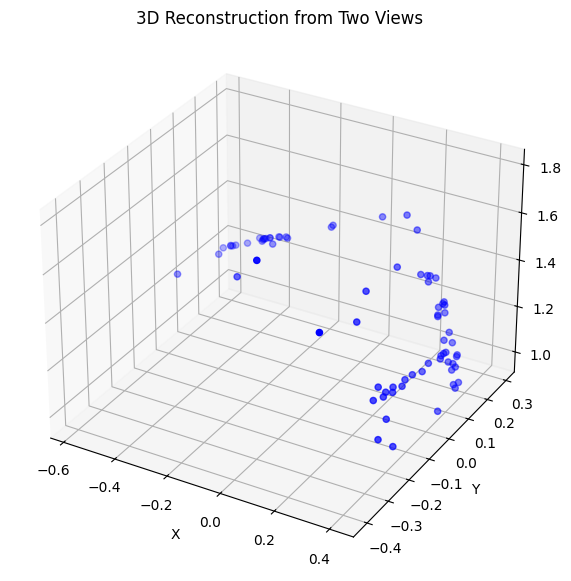

In [10]:
# 투영 행렬 설정
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # 첫 번째 카메라 (기준)
P2 = np.hstack((R, t))  # 두 번째 카메라

# 3D 포인트 재구성
points_4d_hom = cv.triangulatePoints(K @ P1, K @ P2, inliers1.T, inliers2.T)
points_3d = points_4d_hom[:3] / points_4d_hom[3]  # 동차 좌표에서 비동차 좌표로 변환

# 3D 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# X, Y, Z 좌표 추출
X, Y, Z = points_3d[0], points_3d[1], points_3d[2]
ax.scatter(X, Y, Z, c='b', marker='o')

ax.set_title('3D Reconstruction from Two Views')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()